In [1]:
import os
import shutil 
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
from matplotlib.patches import Circle
from skimage.io import imread, imsave
from PIL import Image, ImageEnhance

from preprocess import preprocess

import warnings
warnings.filterwarnings("ignore")

# Load Tables

In [2]:
df_1 = pd.read_excel(
    'data/CalibrationSet_NoduleData.xlsx'
)[:10][['Scan Number', 'Nodule Center x,y Position*', 'Nodule Center Image']]

df_2 = pd.read_excel(
    'data/TestSet_NoduleData_PublicRelease_wTruth.xlsx'
)[:73][['Scan Number', 'Nodule Center x,y Position*', 'Nodule Center Image']]

df = pd.concat([df_1, df_2])

In [3]:
df

,Scan Number,"Nodule Center x,y Position*",Nodule Center Image
0,CT-Training-lc001,"120, 325",135.0
1,CT-Training-lc002,"139, 359",70.0
2,CT-Training-lc003,"375, 323",70.0
3,CT-Training-lc008,"95, 328",65.0
4,CT-Training-lc009,"145, 299",63.0
5,CT-Training-be001,"405, 296",169.0
6,CT-Training-be002,"184, 268",117.0
7,CT-Training-be006,"449, 266",241.0
8,CT-Training-be007,"385, 206",194.0
9,CT-Training-be010,"120, 336",69.0


# Get Image Paths

In [4]:
def get_main_slice(series_path, slice_num):
    images = [f"{series_path}/{image}" for image in os.listdir(series_path)]
    for im in images:
        if pydicom.dcmread(im)[('0020', '0013')].value == slice_num:
            return im

In [5]:
aapm_path = 'data/raw_data'

imgs = []

for i, (_, row) in enumerate(df.iterrows()):
    scan_path, _, im_num = row
    scan_path = f'{aapm_path}/{scan_path}'
    subdir = [d for d in os.listdir(scan_path) if os.path.isdir(f'{scan_path}/{d}')][0]
    scan_path = f'{scan_path}/{subdir}'
    subdir = [d for d in os.listdir(scan_path) if os.path.isdir(f'{scan_path}/{d}')][0]
    scan_path = f'{scan_path}/{subdir}'
    imgs.append(get_main_slice(scan_path, int(im_num)))
    sys.stdout.write(f"\r{i}")

82

In [6]:
df['image_paths'] = imgs
df.reset_index()
df.to_csv('data/aapm_table.csv', index=False)

In [7]:
df = pd.read_csv('data/aapm_table.csv')
df.head()

,Scan Number,"Nodule Center x,y Position*",Nodule Center Image,image_paths
0,CT-Training-lc001,"120, 325",135.0,data/raw_data/CT-Training-lc001/01-03-2007-671...
1,CT-Training-lc002,"139, 359",70.0,data/raw_data/CT-Training-lc002/01-15-2007-603...
2,CT-Training-lc003,"375, 323",70.0,data/raw_data/CT-Training-lc003/01-12-2007-171...
3,CT-Training-lc008,"95, 328",65.0,data/raw_data/CT-Training-lc008/01-10-2007-684...
4,CT-Training-lc009,"145, 299",63.0,data/raw_data/CT-Training-lc009/01-03-2007-169...


120 325


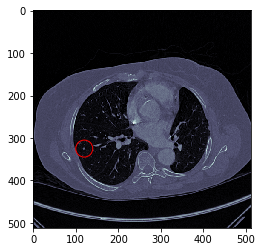

In [8]:
row = df.iloc[0]

xx, yy = [int(p) for p in row['Nodule Center x,y Position*'].split(',')]
print(xx, yy)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(pydicom.dcmread(row.image_paths).pixel_array, cmap='bone')
marker = Circle((xx, yy), 20, fill=False, ec='red')
marker = Circle((xx, yy), 20, fill=False, ec='red')
ax.add_patch(marker)

plt.show()

# Extract Main Slices

In [9]:
if os.path.exists('data/aapm_extracted'):
    shutil.rmtree('data/aapm_extracted')
os.mkdir('data/aapm_extracted')

In [10]:
n = len(df)
for idx, row in df.iterrows():
    sys.stdout.write(f"\rExtracting...{idx+1}/{n}")
    sys.stdout.flush()
    img = pydicom.dcmread(row.image_paths).pixel_array
    imsave(f"data/aapm_extracted/{idx}.tif", img)

Extracting...83/83

52.tif


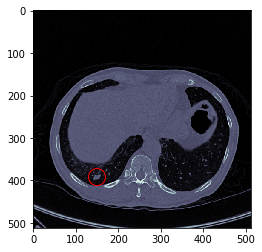

In [11]:
idx = os.listdir('data/aapm_extracted')[np.random.randint(len(os.listdir('data/aapm_extracted')))]
img = imread(f'data/aapm_extracted/{idx}') 
print(idx)

row = df.loc[int(idx[:-4])]
xx, yy = [int(p) for p in row['Nodule Center x,y Position*'].split(',')]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(np.array(img), cmap='bone')
marker = Circle((xx, yy), 20, fill=False, ec='red')
ax.add_patch(marker)

plt.show()

# Process Main Slices

In [12]:
if os.path.exists('data/aapm_processed'):
    shutil.rmtree('data/aapm_processed')

In [13]:
preprocess('data/aapm_extracted', 'data/aapm_processed')

Processing...83/83
Complete.


49.tif


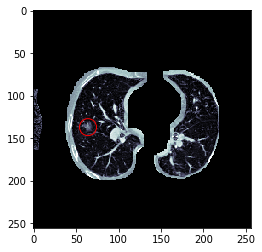

In [14]:
idx = os.listdir('data/aapm_processed')[np.random.randint(len(os.listdir('data/aapm_processed')))]
img = imread(f'data/aapm_processed/{idx}') 
print(idx)

row = df.loc[int(idx[:-4])]
xx, yy = [int(p) for p in row['Nodule Center x,y Position*'].split(',')]
xx = xx//2
yy = yy//2

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(np.array(img), cmap='bone')
marker = Circle((xx, yy), 10, fill=False, ec='red')
ax.add_patch(marker)


plt.show()

In [15]:
idxs = os.listdir('data/aapm_processed')

for idx in idxs:
    img = imread(f'data/aapm_processed/{idx}') 

    row = df.loc[int(idx[:-4])]
    xx, yy = [int(p) for p in row['Nodule Center x,y Position*'].split(',')]
    if img[yy//2][xx//2] == 0: 
        os.remove(f'data/aapm_processed/{idx}')
